<a href="https://colab.research.google.com/github/Adlucent/ga4-churn-prediction/blob/main/III_Preprocessing_and_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# III. Preprocessing & Feature Engineering

1. From BigQuery, import the df that was saved at the end of the last notebook
2. Treat missing values. Inspect columns with at least 1 missing value, determine what to do, and then perform that action. (e.g. imputing, filling with 0, etc.)
3. Clean up and re-bucket categorical variables as needed
4. Clean up numeric columns
5. Inspect dtypes one more time
6. Save df to BigQuery

In this notebook, we'll perform detailed cleanup and feature engineering on the dataset.

Overall, it is good to retain as many predictors (features from the dataset) as possible if they are useable in building a model. The primary reasons we'll remove columns or perform feature engineering are either high cardinality or because they contain duplicative information (i.e. info that is already represented in some way by another column).

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'adl-analytics' #add proj name
region = "US"  # GCP project region

In [ ]:
# Google credentials 
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics 
'''BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI '''

from google.cloud import bigquery
from google.cloud.bigquery import magics, Client, QueryJobConfig

magics.context.project = project_name
client = bigquery.Client(project=magics.context.project)

import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# suppress notebook warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Import BigQuery table saved in the last notebook
This table contains unnested data for users who have made at least one purchase.

In [ ]:
%%bigquery data --project $project_name
SELECT *
FROM `adl-analytics.public_sample_data.churn_ga4_2` # update with your project and dataset name

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# create a copy as in previous notebooks
df = data.copy()

In [ ]:
# check the first 5 rows
df.head(5)

,pk,event_date,event_timestamp,event_name,event_value_in_usd,user_pseudo_id,user_first_touch_timestamp,user_ltv_revenue,device_category,device_mobile_brand_name,device_mobile_model_name,device_operating_system,device_operating_system_version,device_language,device_web_info_browser,device_web_info_browser_version,geo_continent,geo_sub_continent,geo_country,geo_region,geo_city,traffic_source_medium,traffic_source_name,traffic_source_source,ecommerce_total_item_quantity,ecommerce_purchase_revenue_in_usd,ecommerce_purchase_revenue,ecommerce_tax_value_in_usd,ecommerce_tax_value,ecommerce_unique_items,ecommerce_transaction_id,foreign_key,campaign,coupon,engagement_time_msec,ga_session_id,ga_session_number,link_domain,link_url,medium,page_location,page_referrer,page_title,promotion_name,session_engaged,shipping_tier,source,tax,transaction_id,value,items_item_id,items_item_name,items_item_brand,items_item_variant,items_item_category,items_price_in_usd,items_price,items_quantity,items_item_revenue_in_usd,items_item_revenue,items_item_list_id,items_item_list_name,items_item_list_index,items_promotion_name,items_creative_name
0,1607461172697287|view_item,20201208,1607461172697287,view_item,NaN,52407464.0313773688,1605035923000488,0.000,mobile,Huawei,<Other>,Web,10,None,Chrome,87.0,Asia,Western Asia,Qatar,Doha,Doha,referral,(referral),shop.googlemerchandisestore.com,<NA>,NaN,NaN,NaN,NaN,12,(not set),1607461172697287|view_item,None,NaN,1818.000,118606764.0,5.000,None,None,None,https://shop.googlemerchandisestore.com/Google...,None,Men's / Unisex | Apparel | Google Merchandise ...,None,1.000,None,None,NaN,NaN,NaN,GGOEGXXX1039,Google F/C Long Sleeve Tee Ash,(not set),(not set),Home/Apparel/Men's / Unisex/,NaN,30.000,<NA>,NaN,NaN,(not set),Not available in demo dataset,8,(not set),(not set)
1,1607033787353440|view_item,20201203,1607033787353440,view_item,NaN,52407464.0313773688,1605035923000488,0.000,mobile,Huawei,<Other>,Web,10,None,Chrome,87.0,Asia,Western Asia,Qatar,Doha,Doha,organic,(organic),google,<NA>,NaN,NaN,NaN,NaN,12,(not set),1607033787353440|view_item,None,NaN,33620.000,8455008558.0,2.000,None,None,None,https://shop.googlemerchandisestore.com/Google...,None,Womens | Apparel | Google Merchandise Store,None,1.000,None,None,NaN,NaN,NaN,GGOEGXXX1264,Android Garden Tee Orange,(not set),(not set),Home/Apparel/Women's/,NaN,29.000,<NA>,NaN,NaN,(not set),Not available in demo dataset,11,(not set),(not set)
2,1607363262242277|view_item,20201207,1607363262242277,view_item,NaN,52407464.0313773688,1605035923000488,0.000,mobile,Huawei,<Other>,Web,10,None,Chrome,87.0,Asia,Western Asia,Qatar,Doha,Doha,(none),(direct),(direct),<NA>,NaN,NaN,NaN,NaN,12,(not set),1607363262242277|view_item,None,NaN,1982.000,5610058799.0,4.000,None,None,None,https://shop.googlemerchandisestore.com/Google...,None,Sale | Google Merchandise Store,None,1.000,None,None,NaN,NaN,NaN,GGOEAFBA115599,Android Super Hero 3D Framed Art,(not set),(not set),Home/Sale/,NaN,40.000,<NA>,NaN,NaN,(not set),Not available in demo dataset,6,(not set),(not set)
3,1607363262242277|view_item,20201207,1607363262242277,view_item,NaN,52407464.0313773688,1605035923000488,0.000,mobile,Huawei,<Other>,Web,10,None,Chrome,87.0,Asia,Western Asia,Qatar,Doha,Doha,(none),(direct),(direct),<NA>,NaN,NaN,NaN,NaN,12,(not set),1607363262242277|view_item,None,NaN,1982.000,5610058799.0,4.000,None,None,None,https://shop.googlemerchandisestore.com/Google...,None,Sale | Google Merchandise Store,None,1.000,None,None,NaN,NaN,NaN,GGOEAOCB092799,Android Large Trace Journal Black,(not set),(not set),Home/Sale/,NaN,16.000,<NA>,NaN,NaN,(not set),Not available in demo dataset,7,(not set),(not set)
4,1607461172697287|view_item,20201208,1607461172697287,view_item,NaN,52407464.0313773688,1605035923000488,0.000,mobile,Huawei,<Other>,Web,10,None,Chrome,87.0,Asia,Western Asia,Qatar,Doha,Doha,referral,(referral),shop.googlemerchandisestore.com,<NA>,NaN,NaN,NaN,NaN,12,(not set),1607461172697287|view_item,None,NaN,1818.000,118606764

In [ ]:
# check teh shape
df.shape

(2002257, 65)

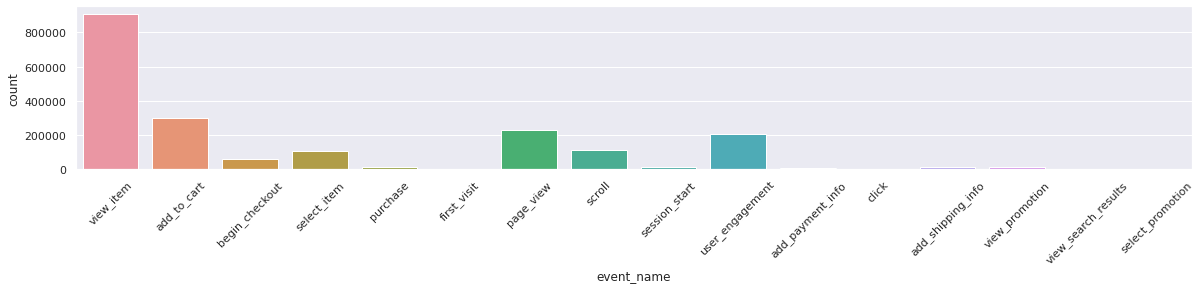

In [ ]:
# check distribution of rows for different events
plt.figure(figsize=(20,3))
sns.countplot(x = "event_name", data = df)
plt.xticks(rotation=45)
plt.show();

## Inspect and clean non-numeric columns

Check the number of unique values in each non-numeric column.

In [ ]:
obj_col = list(df.select_dtypes(['object']).columns)

# print number of unique values in each object column
for col in obj_col:
    print(col)
    print(df[col].nunique())
    print("*" * 20)

pk
778146
********************
event_date
92
********************
event_name
16
********************
user_pseudo_id
4419
********************
device_category
3
********************
device_mobile_brand_name
8
********************
device_mobile_model_name
10
********************
device_operating_system
6
********************
device_operating_system_version
11
********************
device_language
9
********************
device_web_info_browser
6
********************
device_web_info_browser_version
10
********************
geo_continent
6
********************
geo_sub_continent
19
********************
geo_country
101
********************
geo_region
316
********************
geo_city
511
********************
traffic_source_medium
6
********************
traffic_source_name
5
********************
traffic_source_source
5
********************
ecommerce_transaction_id
4452
********************
foreign_key
778146
********************
campaign
12
********************
ga_session_id
15723
**************

Perform the first round of data cleaning by removing some of the special characters and spaces within column values.


In [ ]:
for col in obj_col:
    df.loc[df[col] == "<Other>", col] = "Other"
    df.loc[df[col] == "(none)", col] = "none"
    df.loc[df[col] == "(data deleted)", col] = "data_deleted"
    df.loc[df[col] == "(not set)", col] = "not_set"
    df.loc[df[col] == "(referral)", col] = "referral"
    df.loc[df[col] == "(organic)", col] = "organic"
    df.loc[df[col] == "(direct)", col] = "direct"

In [ ]:
# trim extra white space from entire df
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### Start with cleaning obj cols with 10 or fewer unique values
These will be easiest, we'll handle more complex columns in the following steps.

In [ ]:
nunique = df[obj_col].nunique()
obj_ten_vals = nunique[nunique <= 10].index

In [ ]:
for col in obj_ten_vals:
    print(df[col].value_counts())
    print("*" * 50)

desktop    1148911
mobile      807415
tablet       45931
Name: device_category, dtype: int64
**************************************************
Apple        847083
Google       706455
Samsung      157394
Other        154113
Xiaomi        43654
Microsoft     42176
Huawei        26702
Mozilla       24680
Name: device_mobile_brand_name, dtype: int64
**************************************************
Chrome        569248
iPhone        428226
Other         422561
Safari        385556
ChromeBook    103773
Edge           37084
iPad           27019
Firefox        24680
Pixel 4 XL      2102
Pixel 3         2008
Name: device_mobile_model_name, dtype: int64
**************************************************
Web          1180449
iOS           232874
Windows       231775
Android       168108
Macintosh     138552
Other          50499
Name: device_operating_system, dtype: int64
**************************************************
en-us    627924
en-gb     99462
en        50990
zh        44534
en-ca    

#### Column cleanup on the above features

Note that in this section, any cleanup or feature engineering done will vary depending on your dataset. The steps below are meant to serve as an example of how to process a dataset in preparation for building a churn model. 

In [ ]:
# clean device_mobile_model_name by grouping all Pixel values as Pixel
df.loc[
    (df["device_mobile_model_name"] == "Pixel 4 XL")
    | (df["device_mobile_model_name"] == "Pixel 3"),
    "device_mobile_model_name"
] = "Pixel"

In [ ]:
# clean device_language by removing everything after the hyphen
df['device_language'] = df['device_language'].str.split('-').str[0]

In [ ]:
# clean link_url; replace values with 1 and 0 to represent that a value exists or does not exist in the column
df.loc[~df["link_url"].isnull(),"link_url"] = 1
df.loc[df["link_url"].isnull(),"link_url"] = 0

In [ ]:
# replace/fix special characters and spaces where they exist in several additional columns

df['device_web_info_browser_version'] = df['device_web_info_browser_version'].str.replace('.', '_', regex = True)

df['traffic_source_source'] = df['traffic_source_source'].str.replace('.', '_', regex = True)

df['items_item_brand'] = df['items_item_brand'].str.replace('#', '', regex = True)
df['items_item_brand'] = df['items_item_brand'].str.replace(' ', '_', regex = True)
df["items_item_brand"] = df["items_item_brand"].str.replace(r'^\s*$', "none", regex=True) # fills white space cells with "none"

df["items_promotion_name"] = df["items_promotion_name"].str.replace(r'^\s*$', "none", regex=True) # fills white space cells with "none"
df["items_promotion_name"] = df["items_promotion_name"].str.replace(' ', '_', regex=True)

df["items_creative_name"] = df["items_creative_name"].str.replace(' ', '_', regex=True)

df["device_web_info_browser"] = df["device_web_info_browser"].str.replace(' ', '_', regex=True)

In [ ]:
# drop items_item_list_name because no useful values are available, and link domain because the information is represented in other columns
df.drop("items_item_list_name",axis=1,inplace=True)
df.drop("link_domain",axis=1,inplace=True)

In [ ]:
# check the columsn again to confirm everything is fixed as expected
obj_col = list(df.select_dtypes(['object']).columns)
nunique = df[obj_col].nunique()

obj_ten_vals = nunique[nunique <= 10].index
for col in obj_ten_vals:
    print(df[col].value_counts())
    print("*" * 50)

desktop    1148911
mobile      807415
tablet       45931
Name: device_category, dtype: int64
**************************************************
Apple        847083
Google       706455
Samsung      157394
Other        154113
Xiaomi        43654
Microsoft     42176
Huawei        26702
Mozilla       24680
Name: device_mobile_brand_name, dtype: int64
**************************************************
Chrome        569248
iPhone        428226
Other         422561
Safari        385556
ChromeBook    103773
Edge           37084
iPad           27019
Firefox        24680
Pixel           4110
Name: device_mobile_model_name, dtype: int64
**************************************************
Web          1180449
iOS           232874
Windows       231775
Android       168108
Macintosh     138552
Other          50499
Name: device_operating_system, dtype: int64
**************************************************
en    806239
zh     44534
fr     24567
es     23540
de     12331
ko     10086
Name: device_lan

### Inspect obj cols with between 11 and 50 unique values

In [ ]:
nunique = df[obj_col].nunique()
obj_fifty_vals = (
    nunique[
        (nunique > 10) 
        & (nunique <= 50)
    ]
).index

In [ ]:
for col in obj_fifty_vals:
    print(df[col].value_counts())
    print("*" * 50)

view_item              906923
add_to_cart            299477
page_view              228328
user_engagement        209469
scroll                 112920
select_item            106009
begin_checkout          60934
view_promotion          16070
purchase                16005
session_start           15521
add_shipping_info       11588
add_payment_info        11382
first_visit              3525
view_search_results      2818
select_promotion          681
click                     607
Name: event_name, dtype: int64
**************************************************
Other                    741204
10                       468575
Windows 10               201462
Intel 10.15              180380
iOS 14.3                  91387
Android 10                83719
iOS 14.2                  79868
Macintosh Intel 10.15     79330
Macintosh Intel 11.1      29671
Android 9                 28621
Windows 7                 18040
Name: device_operating_system_version, dtype: int64
**********************************

In [ ]:
# for device_operating_system_version, extract only last part of string since we already have the operating system in another column
df["device_operating_system_version"] = df["device_operating_system_version"].str.split(" ").str[-1]

In [ ]:
df['geo_sub_continent'] = df['geo_sub_continent'].str.replace(' ', '_', regex = True) # replace spaces with underscores
df["campaign"] = df["campaign"].str.split("_").str[0] # strip everything after the underscore

In [ ]:
# from shipping_tier, extracting provider and type into separate columns
df["shipping_tier_provider"] = df["shipping_tier"].str.split(" ").str[0] # extract shipping provider
df['shipping_tier'] = df['shipping_tier'].str.split('-').str[0] # drop first hyphen and everything after where a hyphen exists

df['shipping_tier_type'] = df['shipping_tier'].str.extract(r'\s(.*)') # keep everything after the first white space
df['shipping_tier_type'] = df['shipping_tier_type'].str.replace(' ', '_', regex = True) # replace spaces with underscores

In [ ]:
# convert shipping_tier_type into three values: Ground, Rush and Unknown
df.loc[df["shipping_tier_type"] == "Shipping", "shipping_tier_type"] = "Unknown"

df.loc[
    (df["shipping_tier_type"] != "Ground")
    & (df["shipping_tier_type"] != "Unknown"),
    "shipping_tier_type"
]="Rush"

In [ ]:
# clean up values in items_item_variant by making them consistent or grouping similar ones together
replaceStruct = {
    "items_item_variant": {
        "MD": "MD",
        "LG": "LG", 
        "SM": "SM",
        "XL": "XL", 
        "XS": "XS",
        "XXS": "XXS",
        "2XL": "XXL",
        "3XL": "XXXL",
        "18/24 MONTHS": "Baby",
        "3/6 MONTHS": "Baby",
        "6/12 MONTHS": "Baby",
        "12/18 MONTHS": "Baby",
        "6M": "Baby",
        "12M": "Baby",
        "18M": "Baby",
        "24M": "Baby",
        "NEWBORN": "Baby",
        "2T": "Toddler",
        "3T": "Toddler",
        "4T": "Toddler",
        "5T": "Toddler",
        "5/6T": "Toddler",
        "RED": "RED",
        "BLUE": "BLUE",
        "GREEN": "GREEN",
        "not_set": "not_set",
        "Single Option Only": "Single_Option_Only",
        "Choose Size": "none",
        "No options available": "none",
        "Choose Color": "none"
    },
}
df = df.replace(replaceStruct)

In [ ]:
# fills blank space cells containing only white space with "none"
df["items_item_variant"] = df["items_item_variant"].str.replace(r'^\s*$', "none", regex=True) 

In [ ]:
# drop these cols for the following reasons
df.drop("source",axis=1,inplace=True) # high cardinality; much of the column is already represented in other columns as well
df.drop("shipping_tier",axis=1,inplace=True) # dropping original column since we extracted values into new columns
df.drop("items_item_list_index",axis=1,inplace=True) # index representation of items_item_list_name; duplicative data

### Inspect obj cols with between 51 and 100 unique values

In [ ]:
obj_col = list(df.select_dtypes(['object']).columns)
nunique = df[obj_col].nunique()
obj_onehun_vals = (
    nunique[
        (nunique > 50) 
        & (nunique <= 100)
    ]
).index

for col in obj_onehun_vals:
    print(df[col].value_counts())
    print("*" * 50)

20201211    70430
20201209    67129
20201215    61073
20201130    59523
20201210    58960
20201216    55768
20201208    52190
20201214    50928
20210120    48526
20201217    47710
20201204    45222
20201212    43933
20201201    39871
20201218    39500
20201202    37349
20201207    36658
20201205    34408
20201127    34405
20210122    33918
20201124    33864
20201125    32084
20201203    31609
20201223    29217
20201128    28760
20201213    27411
20201117    25952
20201222    24597
20210119    24410
20201126    24377
20210121    24022
20201221    23438
20201120    22181
20210125    20209
20201110    19639
20201103    19617
20201123    19346
20201116    18865
20201129    18636
20210112    18129
20201111    18072
20201118    17785
20201113    17651
20201219    17479
20201106    16830
20201228    16732
20210115    16362
20210114    16070
20210106    15899
20210126    15719
20201206    15677
20201102    15544
20201112    15446
20201119    15212
20210128    15097
20210113    14681
20210123  

In [ ]:
# convert event_date data type to DATETIME
df["event_date"] = pd.to_datetime(df["event_date"])

In [ ]:
# clean up items_item_category to reflect consistent category names
replaceStruct = {
    "items_item_category": {
        "Home/Apparel/Men's / Unisex/": "Apparel",
        "Home/Sale/": "Sale",
        "Home/Apparel/Women's/": "Apparel",
        "Lifestyle/Drinkware/": "Lifestyle",
        "Lifestyle/Small Goods/": "Lifestyle",
        "Home/Apparel/": "Apparel",
        "Home/Apparel/Kids/": "Apparel",
        "Home/Campus Collection/": "Campus_Collection",
        "Home/Shop by Brand/Google/": "Google",
        "Lifestyle/Bags/": "Lifestyle",
        "Home/New/": "New",
        "Home/Apparel/Hats/": "Apparel",
        "Lifestyle/": "Lifestyle",
        "Home/Stationery/Notebooks/": "Stationary",
        "Home/Eco-Friendly/": "Eco",
        "Apparel": "Apparel",
        "Home/Stationery/": "Stationary",
        "Home/Stationery/Writing/": "Stationary",
        "Home/Shop by Brand/YouTube/": "YouTube",
        "Sale": "Sale",
        "not_set": "not_set",
        "Home/Stationery/Stickers/": "Stationary",
        "Men's / Unisex": "Apparel",
        "Campus Collection": "Campus_Collection",
        "Home/Shop by Brand/": "unknown",
        "New": "New",
        "Drinkware": "Lifestyle",
        "Home/Shop by Brand/Android/": "Android",
        "Home/Apparel/Socks/": "Apparel",
        "Accessories": "Accessories",
        "Bags": "Apparel",
        "Lifestyle": "Lifestyle",
        "Women's": "unknown",
        "Google": "Google",
        "Shop by Brand": "unknown",
        "Small Goods": "Lifestyle",
        "Office": "Other",
        "Clearance": "Sale",
        "Uncategorized Items": "Other",
        "Stationery": "Stationary",
        "Men's T-Shirts/": "Apparel",
        "Eco-Friendly": "Eco",
        "Kids": "unknown",
        "Writing Instruments": "Stationary",
        "Home/Shop by Brand/#IamRemarkable/": "IamRemarkable",
        "Mugs & Tumblers/": "Lifestyle",
        "Notebooks": "Stationary",
        "Writing": "Stationary",
        "Gift Cards": "Gift_Cards",
        "Home/Gift Cards/": "Gift_Cards",
        "Home/Shop by Brand/Google Cloud/": "Google",
        "Android": "Android",
        "Electronics Accessories": "Accessories",
        "Notebooks & Journals": "Stationary",
        "Fun": "unknown",
        "Kid's-Infant/": "unknown",
        "Office/": "unknown",
        "Water Bottles/": "Lifestyle",
        "Hats": "Apparel",
        "Backpacks/": "Apparel",
        "Men's T-Shirts": "Apparel",
        "More Bags/": "Apparel",
        "Accessories/": "Accessories",
        "Shopping and Totes/": "Apparel",
        "Black Lives Matter": "Black_Lives_Matter",
        "Kids-Youth/": "unknown",
        "Home/Black Lives Matter/": "Black_Lives_Matter",
        "Kid's-Toddler/": "unknown",
        "YouTube": "YouTube"      
    },
}
df = df.replace(replaceStruct)

# fills white space cells with "none"
df["items_item_category"] = df["items_item_category"].str.replace(r'^\s*$', "none", regex=True) 

In [ ]:
# inspect categories to make sure the changes above are reflected as expected
df["items_item_category"].value_counts()

Apparel               564020
Lifestyle             236869
Sale                  235537
Stationary             82506
Campus_Collection      55376
Google                 50867
New                    47168
Eco                    27810
unknown                19739
YouTube                15480
not_set                14381
Android                 6740
Other                   6205
Accessories             6089
none                    4577
IamRemarkable            768
Gift_Cards               643
Black_Lives_Matter        18
Name: items_item_category, dtype: int64

### Inspect the remaining obj cols (<100 unique values)

In [ ]:
obj_col = list(df.select_dtypes(['object']).columns)
nunique = df[obj_col].nunique()
obj_max_vals = (nunique[nunique > 100]).index

# since some of these columns have a large number of unique values, we'll start by looking at the number within each column
for col in obj_max_vals:
    print(col)
    print(df[col].nunique())
    print("*" * 30)

pk
778146
******************************
user_pseudo_id
4419
******************************
user_first_touch_timestamp
4311
******************************
geo_country
101
******************************
geo_region
316
******************************
geo_city
511
******************************
ecommerce_transaction_id
4452
******************************
foreign_key
778146
******************************
ga_session_id
15723
******************************
page_location
557
******************************
page_referrer
207
******************************
page_title
475
******************************
items_item_id
1378
******************************
items_item_name
429
******************************
items_item_list_id
376
******************************


In looking at the features above, we'll keep the following ID fields for now as they may be needed for aggregation in the next notebook. 
* `pk`
* `user_pseudo_id`
* `ecommerce_transaction_id`
* `foreign_key`
* `transaction_id`

In [ ]:
# drop these columns due to high cardinality or representation in other existing columns
df.drop([
    'geo_city', 
    'geo_region', 
    'page_location',
    "page_referrer",
    'page_title',
    "items_item_id",
    "items_item_name",
    "items_item_list_id",
    
], axis=1, inplace=True)

In [ ]:
# clean up spaces and special characters in geo_country
df['geo_country'] = df['geo_country'].str.replace(' ', '_', regex = True) # replace spaces with underscores
df['geo_country'] = df['geo_country'].str.replace('&', 'and', regex = True) # replace & with and

In [ ]:
# convert engagement_time_msec, value and tax to numeric dtypes
df["engagement_time_msec"] = df["engagement_time_msec"].astype(float).fillna(0.0)
df["value"] = df["value"].astype(float).fillna(0.0)
df["tax"] = df["tax"].astype(float).fillna(0.0)

### Final data check before saving
Inspect full df one more time, perform any final clean up that may have been missed, and save the table to BigQuery.*italicized text*

In [ ]:
df.shape

(2002257, 54)

In [ ]:
df.describe(datetime_is_numeric = True, include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
pk,2002257,778146,1607919740830105|begin_checkout,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_date,2002257,NaN,NaN,NaN,2020-12-13 15:15:29.797323264,2020-11-01 00:00:00,2020-11-29 00:00:00,2020-12-11 00:00:00,2020-12-25 00:00:00,2021-01-31 00:00:00,NaN
event_timestamp,2002257.000,NaN,NaN,NaN,1607916217119786.000,1604189395117321.000,1606665482059758.000,1607661616825306.000,1608899106007254.000,1612136276965135.000,1942855150245.804
event_name,2002257,16,view_item,906923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_value_in_usd,15555.000,NaN,NaN,NaN,105.502,1.000,41.000,73.000,133.000,1530.000,115.927
user_pseudo_id,2002257,4419,3198843.0611848527,4097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_first_touch_timestamp,1957434.000,4311.000,1608068083242536.000,4097.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_ltv_revenue,2002257.000,NaN,NaN,NaN,21.615,0.000,0.000,0.000,0.000,1530.000,72.885
device_category,2002257,3,desktop,1148911,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_mobile_brand_name,2002257,8,Apple,847083,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.dtypes

pk                                           object
event_date                           datetime64[ns]
event_timestamp                               int64
event_name                                   object
event_value_in_usd                          float64
user_pseudo_id                               object
user_first_touch_timestamp                   object
user_ltv_revenue                            float64
device_category                              object
device_mobile_brand_name                     object
device_mobile_model_name                     object
device_operating_system                      object
device_operating_system_version              object
device_language                              object
device_web_info_browser                      object
device_web_info_browser_version              object
geo_continent                                object
geo_sub_continent                            object
geo_country                                  object
traffic_sour

## Save preprocessed table to BigQuery

In [ ]:
client = bigquery.Client(project = project_name)
table_id = 'public_sample_data.churn_ga4_3' # update your dataset id here as needed
    
job_config = bigquery.LoadJobConfig(
    write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
)

job = client.load_table_from_dataframe(
    df, table_id, job_config = job_config
)

# Wait for the load job to complete.
job.result()

LoadJob<project=adl-analytics, location=US, id=b7a86354-2b12-468e-8c14-9bad74b75a54>